You'll need to edit the paths in the 'renderMesh' function in 'renderer/meshUtils.lua' before running this demo

In [1]:
-- Load helper files
require 'nn'
require 'nngraph'
require 'cunn'
require 'image'

visDir = '../cachedir/demo/' --directory where the meshes, rendrings should be saved
paths.mkdir(visDir)
cmdClean = string.format('rm %s/*.obj; rm %s/*.mtl; rm %s/*.png;', visDir, visDir, visDir)

matio = require 'matio'
cropUtil = dofile('../utils/cropUtils.lua')
quatUtils = dofile('../geometry/quatUtils.lua')
meshUtils = dofile('../renderer/meshUtils.lua')
marchingCubes = dofile('../renderer/marchingCubes.lua')


In [2]:
-- Load networks
cachedir = '../cachedir'
netName = 'chair_depth_poseRegUnsup_nds80_np8_euler_prior1pt0_nc3'
netIter = 80000
snapshotDir = paths.concat(cachedir,'snapshots','shapenet', netName)

predNetShape = torch.load(paths.concat(snapshotDir, 'netShape' .. netIter .. '.t7'))
predNetShape = predNetShape:cuda()

predNetPose = torch.load(paths.concat(snapshotDir, 'netPose' .. netIter .. '.t7'))
predNetPose = predNetPose:cuda()

predNetShape:evaluate()
predNetPose:evaluate()

In [3]:
-- Define utility functions for rotation and transforming to blender coordinate system
function correctQuat(q)
    local q = q:clone()
    q[1] = -q[1]
    local corrMat = torch.Tensor({{0,0,-1}, {1,0,0}, {0,-1,0}})
    local invCorrMat = torch.inverse(corrMat)
    local rotQ = torch.mm(corrMat, quatUtils.quat2rot(q))
    local qc = quatUtils.rot2quat(rotQ)
    qc[1] = -qc[1]
    return qc
end

alignerShape = dofile('../benchmark/align/shape.lua')
sAlign = alignerShape.shapeAlign(nn.AbsCriterion(), {32,32,32})

local gridDim = torch.Tensor({ 0.5,  0.5,  0.5}); local voxDim = 32;
grid = marchingCubes.meshGrid(-1*gridDim,gridDim,{voxDim,voxDim,voxDim})


In [4]:
-- Compute predictions for a test image
imgRgb = image.load(paths.concat('data', 'snet_chair.png'))
local alphaMask = imgRgb[4]:repeatTensor(3,1,1)
imgRgb = torch.cmul(imgRgb:narrow(1,1,3),alphaMask) + 1 - alphaMask

imgRgbVis = imgRgb:clone()
imgRgb = image.scale(imgRgb,64,64)
imgRgb = imgRgb:reshape(1,3,64,64)

imgRgbInput = imgRgb:clone()
pred_voxels = predNetShape:forward(imgRgbInput:cuda()):double()
pred_rots = predNetPose:forward(imgRgbInput:cuda()):double()


Columns 1 to 6
 9.9063e-07  7.9026e-07  1.4708e-05  9.9994e-01  1.3167e-06  3.9362e-05

Columns 7 to 8
 9.3285e-07  1.3255e-08
[torch.CudaTensor of size 1x8]



In [5]:
-- Transform predictions before visualizations
quat = pred_rots[1]:clone()
quat = correctQuat(quat)

shapeInpTensor = torch.Tensor(1,1,32,32,32)
shapeInpTensor:copy(pred_voxels)
visShape = sAlign:transform(shapeInpTensor, quat):squeeze()


In [6]:
-- Render predicted shape from predicted pose
require 'os'
os.execute(cmdClean)

objNameMesh = paths.concat(visDir, 'mesh.obj')
pngName = paths.concat(visDir, 'mesh.png')

local fout = io.open(objNameMesh, 'w')
local vAll, fAll = marchingCubes.march(visShape:double(), grid, 0.5)

meshUtils.appendObj(fout, vAll, fAll)
fout:close()

imgPred = meshUtils.renderMesh(visDir, pngName, 0, 0, 1, 1, 90)

initX = 300;initY = 100;imSize = 400;
imgPred = image.crop(imgPred, initX, initY, initX+imSize, initY+imSize)


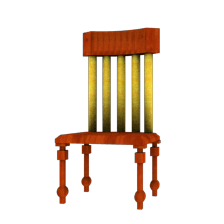

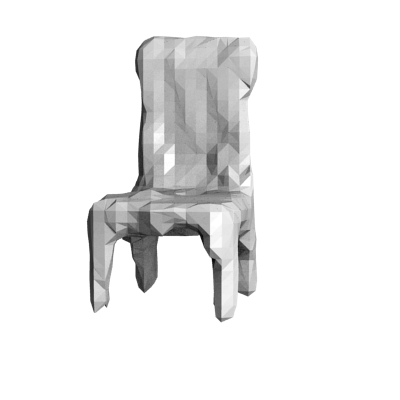

In [7]:
-- Visualize predicted shape from predicted pose
itorch.image(imgRgbVis)
itorch.image(imgPred)